# Utilização de notebooks jupyter e python como CADs

Inicialmente podemos desenhar sketchs com o shapely e plota-los com a Matplotlib e decartes.

In [2]:
import shapely
from shapely import geometry

sketch1_data = [( 0.,0. ), ( 50., 0 ), ( 50., 40. ), ( 100., 40. ), ( 100., 50. ), ( 0., 50. )]
sketch1 = shapely.geometry.Polygon( sketch1_data )


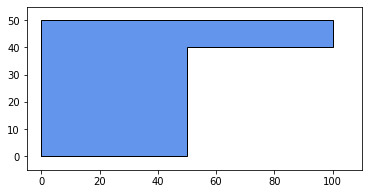

In [3]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch

def plot_polys( polys, xlim = ( -5., 110. ), ylim = ( -5, 55. ), colors=[ "CornflowerBlue", "yellow" ]):
    fig, ax = plt.subplots( figsize=( 6., 3. ))

    cor = 0
    for poly in polys:
        patch = PolygonPatch( poly.buffer( 0 ), facecolor=colors[ cor ], linewidth = 1 )
        cor += 1
        cor = 0 if cor > len( colors ) else cor
        ax.add_patch( patch )

        ax.set_xlim( *xlim )
        ax.set_ylim( *ylim )

    plt.show()

plot_polys([ sketch1 ])

A seguir podemos criar operadores comuns em CADs, como chanfrar ou filetar vertices em sketches.

In [4]:
import shapely
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from shapely.ops import nearest_points

import numpy as np
from math import sqrt


def fillet_2d( sketch, vx_num, radius ):
    r = float( radius )

    # dado um vertice projeta um ponto a 45o para dentro ou fora do poligono, o q for mais adequado, 
    # com a distancia indicada pelo raio
        # recupera as 2 edges onde o vx indicado participa como vetores e normaliza
    vx = sketch.boundary.coords[ vx_num ]
    b = sketch.boundary.coords
    
    edges = [ np.array( b[ k:k+2 ]) for k in range( len( b ) - 1 ) if b[ k ] == vx or b[ k + 1 ] == vx ]
    affected = edges[ 0: 2 ]

    # ordena as edges no sentido dos vertices
    if not np.array_equal( affected[ 0 ][ 1 ], vx ):
        affected = affected[::-1]

    vx = np.array( vx )
    vecs = affected - vx
    vecs = [ vec[ 0 if np.array_equal( vec[ 1 ], [ 0., 0.]) else 1 ] for vec in vecs ]

    for i in range( 2 ):
        norm = np.linalg.norm( vecs[ i ])
        vecs[ i ] /= ( norm if norm != 0 else 1. )

    center_dir = vecs[ 0 ] + vecs[ 1 ]
    norm = np.linalg.norm( center_dir )
    center_dir = center_dir / ( norm if norm != 0 else 1. )

    center = vx + center_dir * r * sqrt( 2 )
    
    # determina 1o pontos de intersecção com o sketch e um circulo criado no centro
    # calculado para o fillet, usando a shapely
    circ = Point( *center ).buffer( r )

    # cruza a 1a edge afetada com o circulo
    edge = LineString( affected[ 0 ])
    pt = ( edge & circ.exterior )
    if type( pt ) is MultiPoint:
        pt = ( pt.geoms[ 0 ].x, pt.geoms[ 0 ].y )
    else:
        pt = ( pt.x, pt.y )

    # encontra o vx do circulo q corresponde a intersecção
    idx = -1
    circ = list( circ.boundary.coords )
    for i in range( len( circ )):
        if edge.distance( Point( circ[ i ])) < 1e-8:
            idx = i
            break
    
    # começa a construir o arco q sera usado para o fillet
    arc = [ circ[ idx ]]

    # determina a direcao a seguir entre os vertices do circulo pela distancia dos vxs
    # antes e depois
    _dir = 1
    dedge = LineString( affected[ 1 ])
    if dedge.distance( Point( circ[ idx + 1 ])) > dedge.distance( Point( circ[ idx - 1 ])):
        _dir = -1

    # segue a lista de vertices e vai acrescentando no arco ate encostar na 2a edge
    while dedge.distance( Point( circ[ idx ])) > 1e-8:
        idx += _dir
        arc.append( circ[ idx ])

    # recria o sketch
    b = list( b )
    rskt = b[ 0:vx_num ] + arc + b[ vx_num+1:]
    
    return Polygon( rskt )



In [5]:
sketch1_1 = fillet_2d( sketch1, 5, 30. )
sketch1_2 = fillet_2d( sketch1_1, 4, 5. )
sketch1_3 = fillet_2d( sketch1_2, 3, 5. )


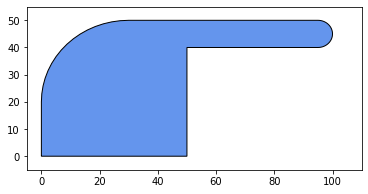

In [6]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch

fig, ax = plt.subplots( figsize=( 6., 3. ))
patch = PolygonPatch( sketch1_3.buffer( 0 ), facecolor="CornflowerBlue", linewidth = 1 )
ax.add_patch( patch )

ax.set_xlim( -5., 110. )
ax.set_ylim( -5., 55. )

plt.show()

Proximo passo é utilizar o pymesh e a numpy-stl para extrudar o sketch num mesh 3D e visualizar o resultado num notebook jupyter.

In [ ]:
import numpy as np
import pyvista as pv

# cria superficie 2D a partir do sketch
_2dpts = sketch1_3.boundary.coords
points = np.hstack(( np.array( _2dpts ), np.zeros(( len( _2dpts ), 1 ))))

lines = [ i for i in range( len( points ))] + [ 0 ]

body1 = pv.PolyData( points )
body1.lines = lines

body1 = body1.extrude(( 0, 0, 50. ), capping=False )


: 

: 

<ipython-input-19-173513293c2b>:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D( figure )


TypeError: object of type 'NoneType' has no len()

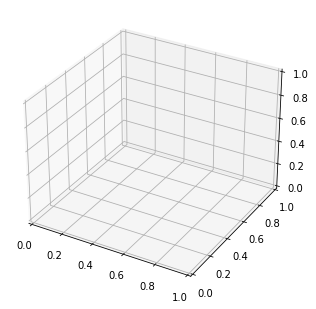

In [19]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

body1.save( "body1.stl" )
body1_mesh = mesh.Mesh.from_file( 'body1.stl' )

figure = pyplot.figure()
axes = mplot3d.Axes3D( figure )

axes.add_collection3d( mplot3d.art3d.Poly3DCollection( body1.vectors ))

# Auto scale to the mesh size
scale = body1.points.flatten()
axes.auto_scale_xyz( scale, scale, scale )

pyplot.show()